In [1]:
import shutil

# importing the sys module
import sys        
 
# appending the directory of mod.py
# in the sys.path list
sys.path.append('../')   

import json
import os
import random
from collections import defaultdict

import torch
from PIL import Image
from torch import nn
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import models
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from torch.optim import lr_scheduler
from torch.optim import Adam
import numpy as np
from sklearn.model_selection import train_test_split

from datetime import datetime

from Common.Optimizers.RangerLars import RangerLars
from Common.Schedulers.GradualWarmupScheduler import GradualWarmupScheduler

import dp6_config as cfg

from dp6_dataset import AgeDiffSameUniformDiffDataset, AgeDiffMixedUniformDiffDataset, AgeDiffMimicDiffDataset, get_error_constrained_dataset
from Common.Datasets.Morph2.data_parser import DataParser
from dp6_train import train_diff_cls_model_iter


from dp6_model import AgeDiffModel, DiffModelConfigType

from tqdm import tqdm

from sklearn import utils



#####################################################
#           Preparations
#####################################################

torch.manual_seed(cfg.RANDOM_SEED)
np.random.seed(cfg.RANDOM_SEED)
random.seed(cfg.RANDOM_SEED)

# if cfg.USE_GPU:
#     device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# else:
device = torch.device("cpu")

print(device)

torch.cuda.empty_cache()

#####################################################
#           Data Loading
#####################################################

with open("im2age_map_test.json", 'r') as im2age_map_test_f:
    im2age_map_test = json.load(im2age_map_test_f)

# Load data
data_parser = DataParser('../Common/Datasets/Morph2/aligned_data/aligned_dataset_with_metadata_uint8.hdf5', small_data=cfg.SMALL_DATA)
data_parser.initialize_data()


x_train, y_train, x_test, y_test = data_parser.x_train,	data_parser.y_train, data_parser.x_test, data_parser.y_test,
if cfg.RANDOM_SPLIT:
    all_images = np.concatenate((x_train, x_test), axis=0)
    all_labels = np.concatenate((y_train, y_test), axis=0)

    x_train, x_test, y_train, y_test = train_test_split(all_images, all_labels, test_size=cfg.TEST_SIZE_FOR_RS, random_state=cfg.RANDOM_SEED)


cpu


In [2]:
face2emb_arr_trn_r = np.load('face2emb_arr_trn.npy', allow_pickle=True)
#     import pdb
#     pdb.set_trace()
#face2emb_arr_trn_r = face2emb_arr_trn_r.item()

face2emb_arr_vld_r = np.load('face2emb_arr_vld.npy', allow_pickle=True)
#face2emb_arr_vld_r = face2emb_arr_vld_r.item()

# shuffle basic aligned test
# x_test_shuffled
# y_test_shuffled


transf = transforms.Compose([
        transforms.RandomResizedCrop(224, (0.9, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([transforms.ColorJitter(
            brightness=0.1,
            contrast=0.1,
            saturation=0.1,
            hue=0.1
        )], p=0.5),
        transforms.RandomApply([transforms.RandomAffine(
            degrees=10,
            translate=(0.1, 0.1),
            scale=(0.9, 1.1),
            shear=5,
            resample=Image.BICUBIC
        )], p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.RandomErasing(p=0.5)
    ])

# transf = transforms.Compose([
#         transforms.Resize(224), # just for testing
# #          transforms.RandomResizedCrop(224, (0.9, 1.0)),
# #          transforms.RandomHorizontalFlip(),
#         transforms.RandomApply([transforms.ColorJitter(
#             brightness=0.1,
#             contrast=0.1,
#             saturation=0.1,
#             hue=0.1
#         )], p=0.5),
# #         transforms.RandomApply([transforms.RandomAffine(
# #             degrees=10,
# #             translate=(0.1, 0.1),
# #             scale=(0.9, 1.1),
# #             shear=5,
# #             resample=Image.BICUBIC
# #         )], p=0.5),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# #        transforms.RandomErasing(p=0.5)
#     ])


train_ds = AgeDiffSameUniformDiffDataset(
    data_set_images=x_train,
    data_set_metadata=y_train,
    min_age=cfg.MIN_AGE,
    age_interval=cfg.AGE_INTERVAL,
    max_age=cfg.MAX_AGE,
    transform=transf,
    copies=1, 
    age_diff_learn_radius_lo=cfg.AGE_DIFF_LEARN_RADIUS_LO,
    age_diff_learn_radius_hi=cfg.AGE_DIFF_LEARN_RADIUS_HI,
    embs=face2emb_arr_trn_r,
    num_references=cfg.NUM_OF_REFS,
    use_embs=cfg.USE_EMBEDDINGS,
    embs_knn=cfg.EMBEDDINGS_KNN
)

print("Training (q trn, r trn) set size: " + str(len(train_ds)))

test_qtst_rtst_ds = AgeDiffSameUniformDiffDataset(
    data_set_images=x_test,
    data_set_metadata=y_test,
    min_age=cfg.MIN_AGE,
    age_interval=cfg.AGE_INTERVAL,
    max_age=cfg.MAX_AGE,
    transform=transf,
    copies=1, 
    age_diff_learn_radius_lo=cfg.AGE_DIFF_LEARN_RADIUS_LO,
    age_diff_learn_radius_hi=cfg.AGE_DIFF_LEARN_RADIUS_HI,
    embs=face2emb_arr_vld_r,
    num_references=cfg.NUM_OF_REFS,
    use_embs=cfg.USE_EMBEDDINGS,
    embs_knn=cfg.EMBEDDINGS_KNN
)

print("Testing (q tst, r tst) set size: " + str(len(test_qtst_rtst_ds)))

test_qtst_rtrn_ds = AgeDiffMixedUniformDiffDataset(
    batrn_set_images=x_train,
    batrn_set_metadata=y_train,
    batst_set_images=x_test,
    batst_set_metadata=y_test,
    min_age=cfg.MIN_AGE,
    age_interval=cfg.AGE_INTERVAL,
    max_age=cfg.MAX_AGE,
    transform=transf,
    copies=1, 
    age_diff_learn_radius_lo=cfg.AGE_DIFF_LEARN_RADIUS_LO,
    age_diff_learn_radius_hi=cfg.AGE_DIFF_LEARN_RADIUS_HI,
    embs_trn=face2emb_arr_trn_r,
    embs_vld=face2emb_arr_vld_r,
    num_references=cfg.NUM_OF_REFS,
    use_embs=cfg.USE_EMBEDDINGS,
    embs_knn=cfg.EMBEDDINGS_KNN
)

print("Testing (q tst, r trn) set size: " + str(len(test_qtst_rtrn_ds)))

x_test_filtered, y_test_filtered, batst_set_filtered_indexes = get_error_constrained_dataset(orig_dataset_images=x_test, 
                                                                                                orig_dataset_metadata=y_test,
                                                                                                age_diff_learn_radius_lo=cfg.APREF_VLD_SET_AGE_DIFF_LEARN_RADIUS_LO,
                                                                                                age_diff_learn_radius_hi=cfg.APREF_VLD_SET_AGE_DIFF_LEARN_RADIUS_HI,#cfg.AGE_DIFF_LEARN_RADIUS_HI,
                                                                                                im2age_map_batst=im2age_map_test)

# apref = Age Predict Reference (dataset is based on (q,r) pairs where r's age is what AgePredict model returns on q)
test_apref_ds = AgeDiffMimicDiffDataset(
    batrn_set_images=x_train,
    batrn_set_metadata=y_train,
    batst_set_images=x_test_filtered,
    batst_set_metadata=y_test_filtered,
    batst_set_indexes=batst_set_filtered_indexes,
    im2age_map_batst=im2age_map_test,
    min_age=cfg.MIN_AGE,
    age_interval=cfg.AGE_INTERVAL,
    max_age=cfg.MAX_AGE,
    transform=transf,
    copies=1, 
    age_radius=cfg.APREF_VLD_SET_AGE_DIFF_LEARN_RADIUS_HI, # this should be the radius of actual learning in order to give correct labels. Not the absolute AGE_RADIUS
    embs_trn=face2emb_arr_trn_r,
    embs_vld=face2emb_arr_vld_r,
    num_references=cfg.NUM_OF_REFS,
    use_embs=cfg.USE_EMBEDDINGS,
    embs_knn=cfg.EMBEDDINGS_KNN
)

print("Testing (q tst where AgePredict(q)  {age_diff_learn_radius_lo} <= error <= {age_diff_learn_radius_hi}, r trn where age(r)=AgePredict(q)) set size: ".format(age_diff_learn_radius_lo=cfg.AGE_DIFF_LEARN_RADIUS_LO, age_diff_learn_radius_hi=cfg.AGE_DIFF_LEARN_RADIUS_HI) + str(len(test_apref_ds)))

x_test_all, y_test_all, batst_set_all_indexes = get_error_constrained_dataset(orig_dataset_images=x_test, 
                                                                                                orig_dataset_metadata=y_test,
                                                                                                age_diff_learn_radius_lo=0,
                                                                                                age_diff_learn_radius_hi=35,#cfg.AGE_RADIUS,
                                                                                                im2age_map_batst=im2age_map_test)


# apref = Age Predict Reference (dataset is based on (q,r) pairs where r's age is what AgePredict model returns on q)
# test_apref_all_ds = DiffPipeline4MimicDiffDataset(
# 	batrn_set_images=x_train,
# 	batrn_set_metadata=y_train,
#     batst_set_images=x_test_all,
#     batst_set_metadata=y_test_all,
#     batst_set_indexes=batst_set_all_indexes,
#     im2age_map_batst=im2age_map_test,
# 	min_age=cfg.MIN_AGE,
# 	age_interval=cfg.AGE_INTERVAL,
#     max_age=cfg.MAX_AGE,
# 	transform=transf,
#     copies=1, 
#     age_radius=cfg.AGE_RADIUS,
#     embs_trn=face2emb_arr_trn_r,
#     embs_vld=face2emb_arr_vld_r#,
#     #num_references=cfg.NUM_OF_REFS
# )

# print("Testing (q tst where AgePredict(q)  {age_diff_learn_radius_lo} <= error <= {age_diff_learn_radius_hi}, r trn where age(r)=AgePredict(q)) set size: ".format(age_diff_learn_radius_lo=cfg.AGE_DIFF_LEARN_RADIUS_LO, age_diff_learn_radius_hi=35) + str(len(test_apref_all_ds))) #cfg.AGE_RADIUS





image_datasets = {
    'train': train_ds,
    'val_qtst_rtst': test_qtst_rtst_ds,
    'val_qtst_rtrn': test_qtst_rtrn_ds,
    'val_apref_ds': test_apref_ds,
    #'val_apref_all_ds': test_apref_all_ds
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val_qtst_rtst', 'val_qtst_rtrn', 'val_apref_ds']}#, 'val_apref_all_ds']}

data_loaders = {
    'train': DataLoader(train_ds, batch_size=1, num_workers=cfg.NUM_OF_WORKERS_DATALOADER, pin_memory=True, shuffle=True, drop_last=True),
    'val_qtst_rtst': DataLoader(test_qtst_rtst_ds, batch_size=cfg.BATCH_SIZE, num_workers=cfg.NUM_OF_WORKERS_DATALOADER, pin_memory=True, shuffle=False, drop_last=True),
    'val_qtst_rtrn': DataLoader(test_qtst_rtrn_ds, batch_size=cfg.BATCH_SIZE, num_workers=cfg.NUM_OF_WORKERS_DATALOADER, pin_memory=True, shuffle=False, drop_last=True),
    'val_apref_ds': DataLoader(test_apref_ds, batch_size=1, num_workers=cfg.NUM_OF_WORKERS_DATALOADER, pin_memory=True, shuffle=False, drop_last=True),
    #'val_apref_all_ds' : DataLoader(test_apref_all_ds, batch_size=cfg.BATCH_SIZE, num_workers=cfg.NUM_OF_WORKERS_DATALOADER, pin_memory=True, shuffle=False, drop_last=True)
}

C:\Users\proj\.conda\envs\my_thesis_py38\lib\site-packages\torchvision\transforms\transforms.py:1361: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  warnings.warn(


Training (q trn, r trn) set size: 44285
Testing (q tst, r tst) set size: 10606
Testing (q tst, r trn) set size: 10606
Testing (q tst where AgePredict(q)  0 <= error <= 3, r trn where age(r)=AgePredict(q)) set size: 7012


In [3]:
face2emb_arr_trn_r[0]
face2emb_arr_vld_r[0]

array([[18.367966 ,  6.1051064,  0.       , ...,  0.       ,  0.       ,
         0.       ]], dtype=float32)

100%|██████████████████████████████████████████████████████████████████████████████| 7012/7012 [09:55<00:00, 11.77it/s]


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1060 samples in 0.008s...
[t-SNE] Computed neighbors for 1060 samples in 0.048s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1060
[t-SNE] Computed conditional probabilities for sample 1060 / 1060
[t-SNE] Mean sigma: 21.564789
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.945908
[t-SNE] KL divergence after 1000 iterations: 0.563604


[Text(0.5, 1.0, 'Age Diff data T-SNE projection')]

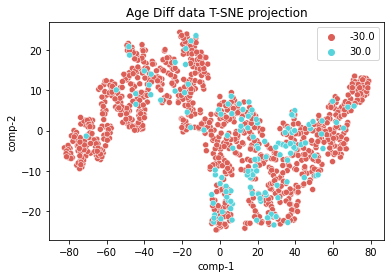

In [4]:
ages_cat = np.array([])
feats = np.array([]).reshape(0, 4096)
#face2emb_map_vld = {}
faces_cat = np.array([]).reshape(0, 224, 224, 3)

j = 0
for i, batch in enumerate(tqdm(data_loaders['train'])):
    ages_cat_cur = batch['age_ref'].numpy() +  batch['age_diff'].numpy()
#     import pdb
#     pdb.set_trace()
    if ages_cat_cur == 30.0 :
        j += 1
        # taking copy 0
        feats_cur = face2emb_arr_trn_r[i] #features['backbone'][0].numpy().reshape(1, 4096)
        feats = np.concatenate((feats, feats_cur), axis=0)
        ages_cat = np.concatenate((ages_cat, -ages_cat_cur), axis=0)
#         if j == 30:
#             break
            
j = 0
for i, batch in enumerate(tqdm(data_loaders['val_apref_ds'])):
    ages_cat_cur = batch['age_ref'].numpy() +  batch['age_diff'].numpy()
    if ages_cat_cur == 30.0 :
        j += 1
        # taking copy 0
        feats_cur = face2emb_arr_vld_r[i] #features['backbone'][0].numpy().reshape(1, 4096)
        feats = np.concatenate((feats, feats_cur), axis=0)
        ages_cat = np.concatenate((ages_cat, ages_cat_cur), axis=0)
#         if j == 30:
#             break
            
        


from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd  

tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(feats)
df = pd.DataFrame()
df["y"] = ages_cat
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", len(np.unique(ages_cat))),
                data=df).set(title="Age Diff data T-SNE projection")

100%|████████████████████████████████████████████████████████████████████████████| 7012/7012 [1:09:45<00:00,  1.68it/s]


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 51297 samples in 0.320s...
[t-SNE] Computed neighbors for 51297 samples in 105.802s...
[t-SNE] Computed conditional probabilities for sample 1000 / 51297
[t-SNE] Computed conditional probabilities for sample 2000 / 51297
[t-SNE] Computed conditional probabilities for sample 3000 / 51297
[t-SNE] Computed conditional probabilities for sample 4000 / 51297
[t-SNE] Computed conditional probabilities for sample 5000 / 51297
[t-SNE] Computed conditional probabilities for sample 6000 / 51297
[t-SNE] Computed conditional probabilities for sample 7000 / 51297
[t-SNE] Computed conditional probabilities for sample 8000 / 51297
[t-SNE] Computed conditional probabilities for sample 9000 / 51297
[t-SNE] Computed conditional probabilities for sample 10000 / 51297
[t-SNE] Computed conditional probabilities for sample 11000 / 51297
[t-SNE] Computed conditional probabilities for sample 12000 / 51297
[t-SNE] Computed conditional probabilities for s

[Text(0.5, 1.0, 'Age Diff data T-SNE projection')]

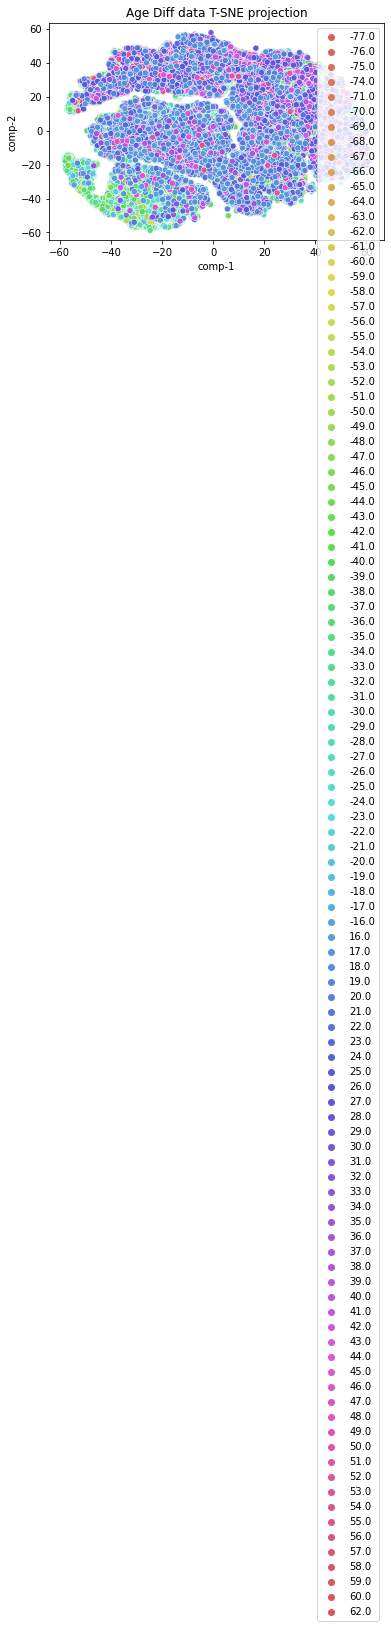

In [5]:
ages_cat = np.array([])
feats = np.array([]).reshape(0, 4096)
#face2emb_map_vld = {}
faces_cat = np.array([]).reshape(0, 224, 224, 3)

j = 0
for i, batch in enumerate(tqdm(data_loaders['train'])):
    ages_cat_cur = batch['age_ref'].numpy() +  batch['age_diff'].numpy()
#     import pdb
#     pdb.set_trace()
    #if ages_cat_cur == 30.0 :
    #j += 1
    # taking copy 0
    feats_cur = face2emb_arr_trn_r[i] #features['backbone'][0].numpy().reshape(1, 4096)
    feats = np.concatenate((feats, feats_cur), axis=0)
    ages_cat = np.concatenate((ages_cat, -ages_cat_cur), axis=0)
#         if j == 30:
#             break
            
j = 0
for i, batch in enumerate(tqdm(data_loaders['val_apref_ds'])):
    ages_cat_cur = batch['age_ref'].numpy() +  batch['age_diff'].numpy()
    #if ages_cat_cur == 30.0 :
    #j += 1
    # taking copy 0
    feats_cur = face2emb_arr_vld_r[i] #features['backbone'][0].numpy().reshape(1, 4096)
    feats = np.concatenate((feats, feats_cur), axis=0)
    ages_cat = np.concatenate((ages_cat, ages_cat_cur), axis=0)
#         if j == 30:
#             break
            
        


from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd  

tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(feats)
df = pd.DataFrame()
df["y"] = ages_cat
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", len(np.unique(ages_cat))),
                data=df).set(title="Age Diff data T-SNE projection")